C:\Users\xiaoy\AppData\Local\Temp\ipykernel_34172\2155004444.py:65: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')


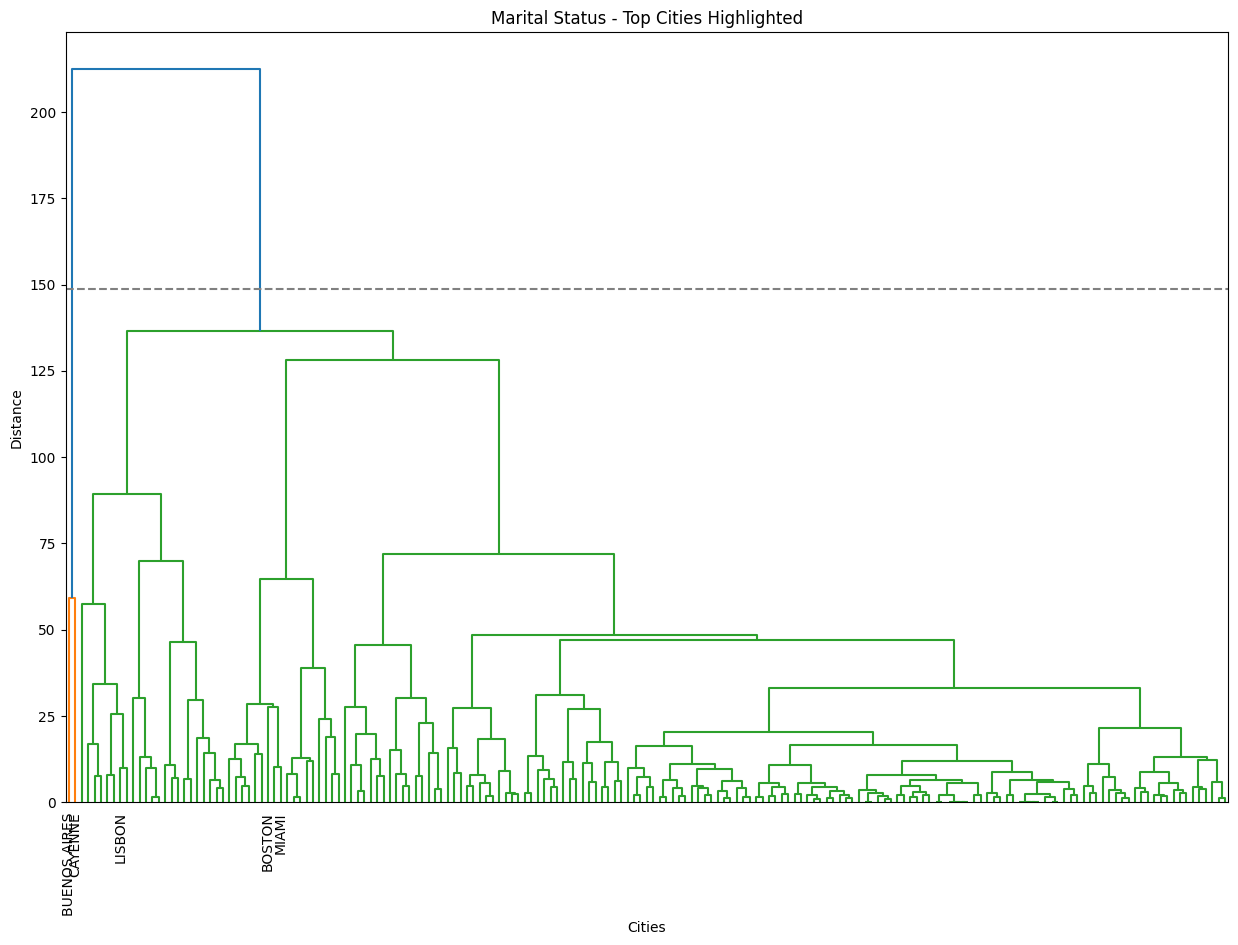

C:\Users\xiaoy\AppData\Local\Temp\ipykernel_34172\2155004444.py:65: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')


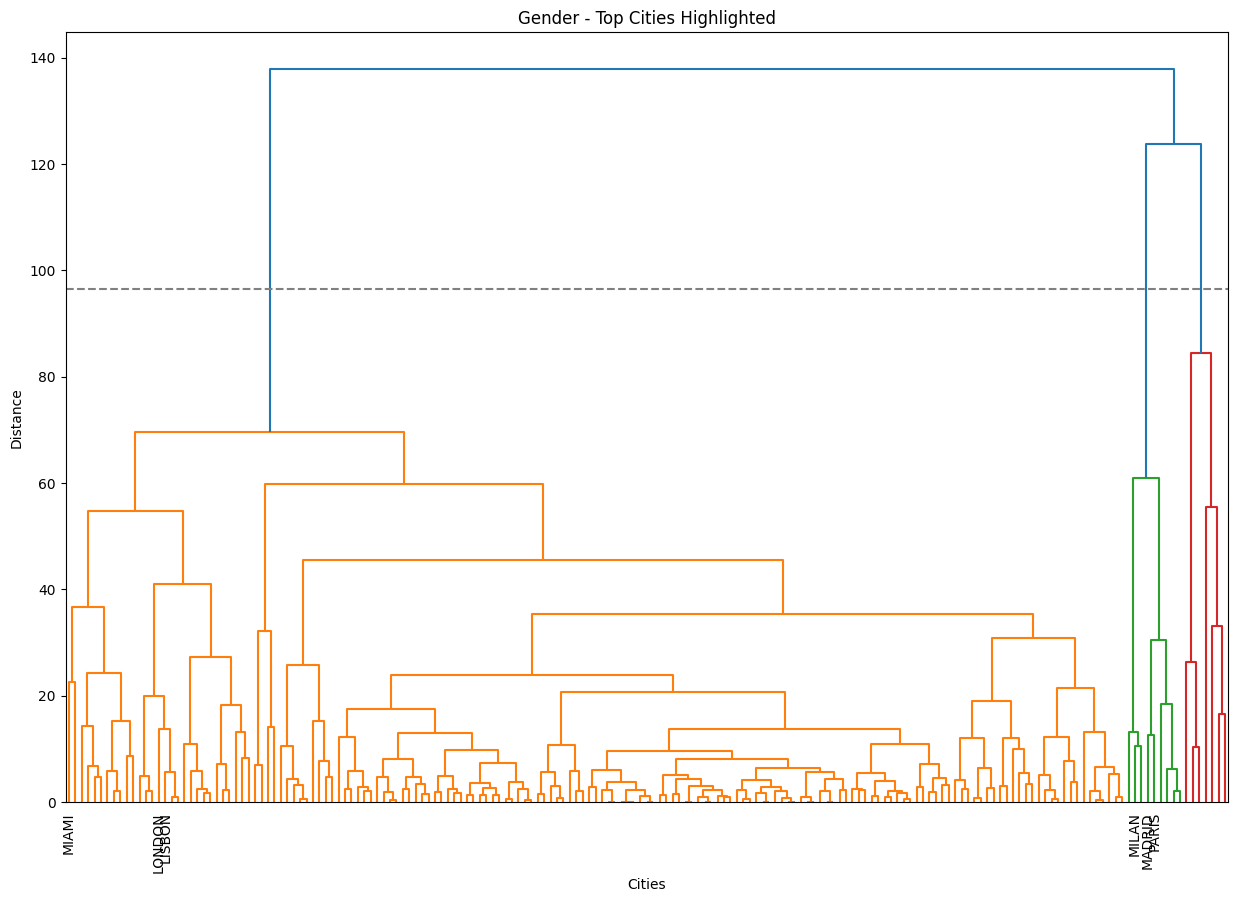

C:\Users\xiaoy\AppData\Local\Temp\ipykernel_34172\2155004444.py:65: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete')


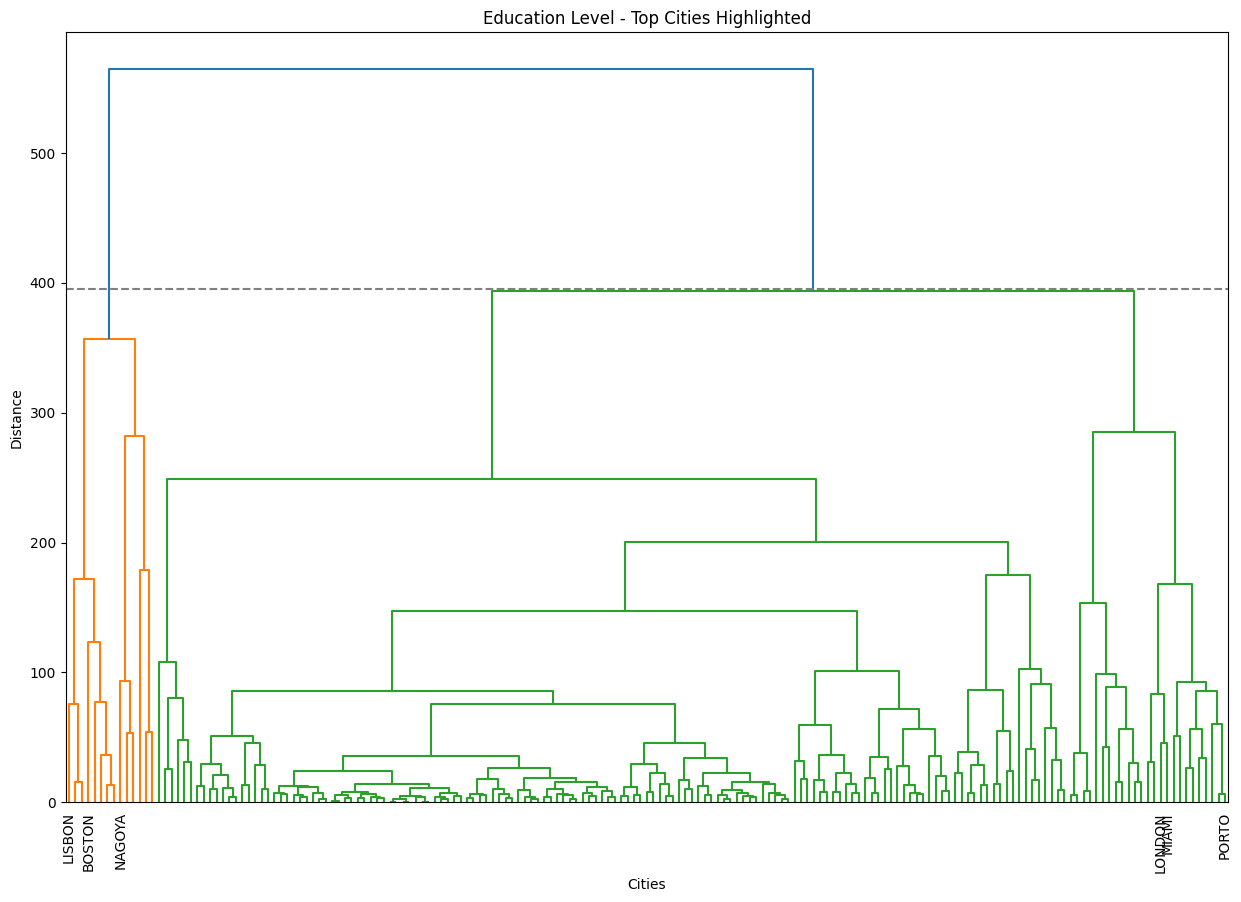

In [1]:
# Re-importing necessary libraries and redefining functions
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

# Re-load the dataset
file_path = 'Desktop/translated_ZZ22.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Creating a long format dataframe
df_long = df.loc[df.index.repeat(df['NUMBER_OF_VOTERS_PROFILE'])]

# Creating wide format dataframes for Marital Status, Gender, and Education Level
df_wide_ms = df_long.pivot_table(index='CITY_NAME', columns='MARITAL_STATUS_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
df_wide_gender = df_long.pivot_table(index='CITY_NAME', columns='GENDER_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
df_wide_education = df_long.pivot_table(index='CITY_NAME', columns='EDUCATION_LEVEL_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)

def dev_multinom(x, y):
    # Kullback-Leibler divergence
    return 2 * np.sum(np.where((x == 0) | (y == 0), 0, x * np.log(x / y)))

def l2_dist(x, y):
    # L2 (Euclidean) distance
    return np.sum((x - y) ** 2)

def cat_dist(x, y, deviance=False, normalize=False):
    wx = np.sum(x)
    wy = np.sum(y)
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    D = dev_multinom if deviance else l2_dist
    if normalize:
        return np.sqrt(.5 * wx / (wx + wy) * D(x, m)) + np.sqrt(.5 * wy / (wx + wy) * D(y, m))
    else:
        return np.sqrt(.5 * wx * D(x, m)) + np.sqrt(.5 * wy * D(y, m))

def ord_dist(x, y, normalize=False):
    wx = np.sum(x)
    wy = np.sum(y)
    k = len(x) # should be equal to len(y)
    x = np.cumsum(x)[:-1]
    y = np.cumsum(y)[:-1]
    m = (x + y) / (wx + wy) # center
    x = x / wx
    y = y / wy
    if normalize:
        return np.sqrt(wx / (wx + wy) * l2_dist(x, m)) + np.sqrt(wy / (wx + wy) * l2_dist(y, m))
    else:
        return np.sqrt(wx * l2_dist(x, m)) + np.sqrt(wy * l2_dist(y, m))

# Adding 'Total' column to each dataframe
df_wide_ms['Total'] = df_wide_ms.sum(axis=1)
df_wide_gender['Total'] = df_wide_gender.sum(axis=1)
df_wide_education['Total'] = df_wide_education.sum(axis=1)

# Redefining the analyze_and_plot function to include the 'Total' column
def analyze_and_plot(df, dist_func, title):
    # Create distance matrix
    dist_matrix = squareform(pdist(df.drop('Total', axis=1), metric=dist_func))
    
    # Perform hierarchical clustering
    Z = linkage(dist_matrix, method='complete')

    # Identify the two main clusters
    max_d = max(Z[:, 2]) * 0.7  # A heuristic to find the distance threshold for the main bifurcation
    clusters = fcluster(Z, max_d, criterion='distance')

    # Adding cluster labels to the dataframe
    df['Cluster'] = clusters

    # Separating the data into two main clusters
    cluster1 = df[df['Cluster'] == 1]
    cluster2 = df[df['Cluster'] == 2]

    # Identifying the top three cities in each cluster by total population
    top3_cluster1 = cluster1.nlargest(3, 'Total').index.tolist()
    top3_cluster2 = cluster2.nlargest(3, 'Total').index.tolist()

    # Combining top cities from both clusters
    top_cities = top3_cluster1 + top3_cluster2

    # Plotting the dendrogram with only top cities labeled
    plt.figure(figsize=(15, 10))
    dendrogram(Z, labels=df.index, leaf_rotation=90, leaf_font_size=10, color_threshold=max_d)

    # Modifying the labels to only show the top cities
    for label in plt.gca().get_xmajorticklabels():
        if label.get_text() not in top_cities:
            label.set_visible(False)

    plt.title(title)
    plt.xlabel('Cities')
    plt.ylabel('Distance')
    plt.axhline(y=max_d, color='gray', linestyle='dashed')  # Threshold line for two main clusters
    plt.show()

# Analyzing and plotting for each category
analyze_and_plot(df_wide_ms, cat_dist, "Marital Status - Top Cities Highlighted")
analyze_and_plot(df_wide_gender, cat_dist, "Gender - Top Cities Highlighted")
analyze_and_plot(df_wide_education, ord_dist, "Education Level - Top Cities Highlighted")
